In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys

import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

In [15]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [16]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [17]:
def get_LOB_data(data_path, asset_name, trade_date):
    LOB_data_path = os.path.join(data_path, asset_name, f'{asset_name}_{trade_date}_34200000_57600000_orderbook_5.csv')
    LOB_data      = pd.read_csv(LOB_data_path,
                                usecols   = [0, 1, 2, 3],
                                engine    = 'c',
                                index_col = None,
                                header    = None,
                                infer_datetime_format = True)

    LOB_messages = pd.read_csv(f'{data_path}/{asset_name}/{asset_name}_{trade_date}_34200000_57600000_message_5.csv', 
                               usecols   = [0, 1, 2, 3],
                               engine    = 'c',
                               index_col = 0,
                               header    = None)
    LOB_data.index = LOB_messages.index
    LOB_data.columns = [f'ask_1', f'ask_volume_1', f'bid_1', f'bid_volume_1']
    LOB_data.index.name = 'time'
    LOB_data = LOB_data.reset_index(drop=False).groupby('time').last()
    
    return LOB_data, LOB_messages

In [18]:
# LOB_data

In [19]:
# imb_model  = pd.read_pickle('../nb_trading/imb_model.pkl')
# macd_model = pd.read_pickle('../nb_trading/macd_model.pkl')


# Load Data & Signals

In [20]:
from AOE.utils import get_meta_order_df, verbose_print
from AOE.plots import rescale_plot
from AOE.plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots, analyze_meta_order

In [21]:
data_path     = pathlib.Path(os.path.abspath(os.path.join('..','..')), "AOE3_data")
reward_path   = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Rewards")
feature_path  = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Features")

asset_names    = ("BIDU", "COST", "CSCO", "GILD", "DELL", "GOOG", "INTC") 
tick_size     = 0.01

1: Submission of a new limit order <br>
2: Cancellation (partial deletion of a limit order) <br>
3: Deletion (total deletion of a limit order) <br>
4: Execution of a visible limit order <br>
5: Execution of a hidden limit order <br>
7: Trading halt indicator (detailed information below) <br>

In [33]:
from itertools import accumulate

def cum_concat(x):
    return list(accumulate(x))
f = lambda x: cum_concat([[i] for i in x])

tick_size     = 0.01

fwd_cols = []
fwd_col_l = (1, 5, 10, 20, 50, 40, 60, 100)#, 300, 500, 1000)
for w in fwd_col_l:
    fwd_cols += [f'fwd_price_move_{w}']

def add_fwd_cols(fwd_cols, _LOB_data):
    for col in fwd_cols:
        fwd_w = int(col.split('_')[-1])
        _LOB_data[col] = _LOB_data['mid_price'].diff(fwd_w).shift(-fwd_w)


In [104]:
asset_name = 'GILD'

all_data_frames = {}
for filename in os.listdir(os.path.join(data_path, asset_name)):
        #i += 1
        f = os.path.join(os.path.join(data_path, asset_name),filename)
        if 'orderbook' in f:
            if os.path.isfile(f):
                trade_date = f.split('_')[2]
                print(trade_date)
                try:
                    LOB_data, LOB_messages      = get_LOB_data(data_path, asset_name, trade_date)

                    # all limit orders and cancellations
                    tmpINDICFIRSTLIMIT = LOB_data.loc[LOB_messages[LOB_messages.iloc[:, 0].apply(lambda x: x in (1, 2, 3))].index].diff(1)
                    # keep only impact on first queue
                    tmpINDICFIRSTLIMIT = tmpINDICFIRSTLIMIT[((tmpINDICFIRSTLIMIT.ask_volume_1!=0) | (tmpINDICFIRSTLIMIT.bid_volume_1!=0))]

                    # keep the market orders !
                    LOB_data = pd.concat((LOB_data.loc[ LOB_messages[ ((LOB_messages.iloc[:, 0]==4) | (LOB_messages.iloc[:, 0]==5)) ].index ],
                                          LOB_data.loc[tmpINDICFIRSTLIMIT.index]), axis=0).sort_index()
                    
                    # all cancelation should have same code
                    LOB_messages.loc[LOB_messages[LOB_messages.iloc[:, 0].apply(lambda x: x in (2, 3))].index, "1"] = 'C'
                    LOB_messages.loc[LOB_messages[LOB_messages.iloc[:, 0].apply(lambda x: x in (1,))].index, "1"] = 'L'
                    LOB_messages.loc[LOB_messages[LOB_messages.iloc[:, 0].apply(lambda x: x in (4, 5))].index, "1"] = 'M'
                    
                    # select only relevant data
                    _LOB_messages = LOB_messages.loc[LOB_data.index].reset_index()
                    _LOB_data     = LOB_data.loc[LOB_data.index].reset_index()
                    _LOB_data["message"] = _LOB_messages[f"1"]
                    
                    # create sequences
                    sequence_lengths = (2, 3, 5)
                    for sequence_length in sequence_lengths:
                        _LOB_data[f"sequence_{sequence_length}"] = ""
                        for i in range(sequence_length-1, -1, -1):
                            _LOB_data[f"sequence_{sequence_length}"] += _LOB_data[f"message"].shift(i)

                    # create mid_price and ba spread
                    _LOB_data['mid_price'] = (_LOB_data['ask_1'] + _LOB_data['bid_1'])/2/ 10000
                    _LOB_data['ba_spread'] = (_LOB_data['ask_1'] - _LOB_data['bid_1'])/ 10000
                    
                    # crete forward columns
                    add_fwd_cols(fwd_cols, _LOB_data)
                    
                    # store data
                    all_data_frames[f] = _LOB_data
                except Exception as e:
                    print('Error for file ', f, ':', str(e))

2022-11-01
2022-12-14
2022-12-05
2022-11-10
2022-12-20
2022-11-29
2022-10-12
2022-10-03
2022-12-19
2022-10-26
2022-12-08
2022-10-24
2022-10-10
2022-12-22
2022-12-07
2022-12-16
2022-11-03
2022-11-11
2022-12-15
2022-12-21
2022-11-25
2022-11-28
2022-10-13
2022-10-27
2022-12-09
2022-10-25
2022-10-11
2022-12-23
2022-11-02
2022-10-28
2022-12-06
2022-11-30
2022-11-21
2022-11-15
2022-11-04
2022-11-09
2022-10-06
2022-10-17
2022-10-04
2022-10-21
2022-12-13
2022-12-02
2022-11-17
2022-10-18
2022-11-23
2022-12-01
2022-11-14
2022-11-08
2022-10-07
2022-10-05
2022-10-14
2022-10-20
2022-10-31
2022-11-16
2022-12-12
2022-11-07
2022-10-19
2022-11-22


In [106]:
alldata = pd.concat((all_data_frames[f] for f in all_data_frames.keys()), axis=0).reset_index()

In [107]:
baspread   = _LOB_data.ba_spread.mean()
for fwd_col in fwd_cols:
    alldata[fwd_col] = alldata[fwd_col] / baspread

In [108]:
fwd_window = 50
seql       = 5
stats_ = (alldata.loc[:, [f'sequence_{seql}', f"fwd_price_move_{fwd_window}"]].groupby(f'sequence_{seql}')).describe()
stats_

fwd_price_move_50                                                                  
                       count      mean       std        min       25%  50%      75%        max
sequence_5                                                                                    
CCCCC               188673.0  0.009202  0.781898 -10.903865 -0.302885  0.0  0.60577   9.995209
CCCCL               215351.0  0.004356  0.809791 -12.418290 -0.302885  0.0  0.60577  10.298094
CCCCM                16032.0  0.007689  0.848954  -8.177899 -0.302885  0.0  0.60577   7.572128
CCCLC               192013.0  0.003309  0.801606 -11.509635 -0.605770  0.0  0.60577  12.418290
CCCLL               272667.0  0.004755  0.817789 -12.418290 -0.605770  0.0  0.60577   9.995209
...                      ...       ...       ...        ...       ...  ...      ...        ...
MMMLL               161504.0  0.005178  0.923203 -16.355797 -0.605770  0.0  0.60577  15.750027
MMMLM                22351.0 -0.000081  1.054283 -15.144257 -0.605770  0.0  0.60577  12.418290
MMMMC                33673.0  0.004533  0.999230 -15.447142 -0.605770  0.0  0.60577  11.812520
MMMML               204618.0  0.004981  0.935271 -15.447142 -0.605770  0.0  0.60577  14.538486
MMMMM              2542278.0  0.005327  0.683426 -16.052912  0.000000  0.0  0.00000  16.961567

[243 rows x 8 columns]

Text(0.5, 1.0, 'Predictive power of sequences')

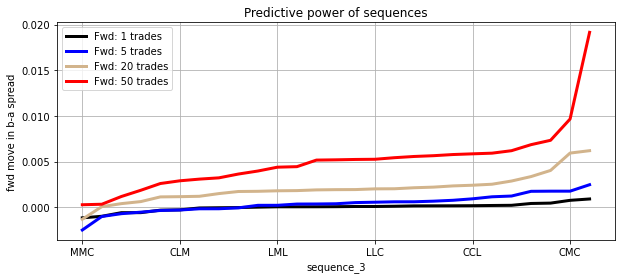

In [109]:
fwd_window = 1
seql       = 3

colors = ('k', 'b', 'tan', 'r')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for (fwd_window, clr) in zip((1, 5, 20, 50), colors):
    (alldata.loc[:, [f'sequence_{seql}', f"fwd_price_move_{fwd_window}"]].groupby(f'sequence_{seql}'
                    ).mean()).iloc[:, 0].sort_values().plot(ax=ax, color=clr, lw=3)
ax.legend([f'Fwd: {i} trades' for i in (1, 5, 20, 50)])
ax.grid('both')
ax.set_ylabel('fwd move in b-a spread')
ax.set_title('Predictive power of sequences')
#ax.set_xticks(alldata[f'sequence_{seql}'].dropna().unique())

Text(0.5, 1.0, 'Predictive power of sequences')

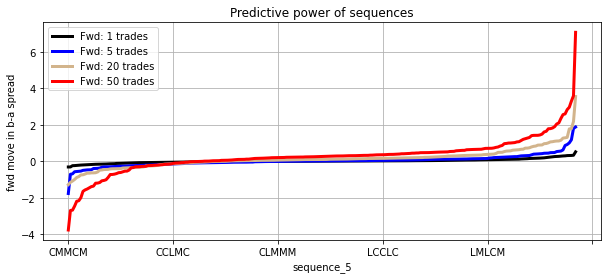

In [110]:
seql   = 5

colors = ('k', 'b', 'tan', 'r')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for (fwd_window, clr) in zip((1, 5, 20, 50), colors):
    ((alldata.loc[:, [f'sequence_{seql}', f"fwd_price_move_{fwd_window}"]].groupby(f'sequence_{seql}'
                    ).mean()).iloc[:, 0].sort_values()/alldata.ba_spread.mean()) .plot(ax=ax, color=clr, lw=3)
ax.legend([f'Fwd: {i} trades' for i in (1, 5, 20, 50)])
ax.grid('both')
ax.set_ylabel('fwd move in b-a spread')
ax.set_title('Predictive power of sequences')
#ax.set_xticks(alldata[f'sequence_{seql}'].dropna().unique())

In [111]:
#seq_results = {}
#seq_results['DELL'] = alldata
#seq_results['INTC'] = alldata
#seq_results['GILD'] = alldata

In [179]:
asset_names = ('DELL', 'INTC', 'GILD')
cv

fwd_window_ls  = (1, 5, 20, 50)
seqls          = (3, 5)

both_seq_pred =  pd.concat((pd.concat((pd.concat( ( seq_results[asset_name].loc[:, [f'sequence_{seql}', f"fwd_price_move_{fwd_window_l}"]
                                                                                    ].groupby(f'sequence_{seql}'
                                                                                    ).mean(
                                                                                    ).sort_values(by=f"fwd_price_move_{fwd_window_l}"
                                                                                    ).rename(columns={f"fwd_price_move_{fwd_window_l}":f'{asset_name}_fwd{fwd_window_l}_seq{seql}'}
                                                                                    ) for asset_name in asset_names
                                                  ), 
                                        axis=1) for fwd_window_l in fwd_window_ls), axis=1
                                      ) for seql in seqls
                           ), axis=1)

both_seq_pred_std =  pd.concat((pd.concat((pd.concat( ( seq_results[asset_name].loc[:, [f'sequence_{seql}', f"fwd_price_move_{fwd_window_l}"]
                                                                                    ].groupby(f'sequence_{seql}'
                                                                                    ).std(
                                                                                    ).sort_values(by=f"fwd_price_move_{fwd_window_l}"
                                                                                    ).rename(columns={f"fwd_price_move_{fwd_window_l}":f'{asset_name}_fwd{fwd_window_l}_seq{seql}'}
                                                                                    ) for asset_name in asset_names
                                                  ), 
                                        axis=1) for fwd_window_l in fwd_window_ls), axis=1
                                      ) for seql in seqls
                           ), axis=1)

for col in both_seq_pred.columns:
    asset_name = col.split('_')[0]
    both_seq_pred[col]     = both_seq_pred[col]     / seq_results[asset_name].ba_spread.mean()
    both_seq_pred_std[col] = both_seq_pred_std[col] / seq_results[asset_name].ba_spread.mean()

In [180]:
both_seq_pred_std.sort_index()

,DELL_fwd1_seq3,INTC_fwd1_seq3,GILD_fwd1_seq3,DELL_fwd5_seq3,INTC_fwd5_seq3,GILD_fwd5_seq3,DELL_fwd20_seq3,INTC_fwd20_seq3,GILD_fwd20_seq3,DELL_fwd50_seq3,...,GILD_fwd1_seq5,DELL_fwd5_seq5,INTC_fwd5_seq5,GILD_fwd5_seq5,DELL_fwd20_seq5,INTC_fwd20_seq5,GILD_fwd20_seq5,DELL_fwd50_seq5,INTC_fwd50_seq5,GILD_fwd50_seq5
CCC,6.411664,3.408632,6.603303,12.565519,7.541985,13.720765,24.25737,14.565178,26.831145,38.260213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCCCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.326373,12.029952,7.428517,13.305417,23.205312,14.354820,25.902946,36.571158,22.918993,42.131431
CCCCL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.578122,12.321426,7.523130,13.776245,23.817846,14.562634,26.706331,37.707608,23.227331,43.634418
CCCCM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.751122,12.609410,7.698469,14.931901,25.738610,14.638381,28.082194,42.173329,23.448736,45.744662
CCCLC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.463771,13.371681,7.624274,13.507494,25.908904,14.778825,26.614384,40.989545,23.652149,43.193414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMMLL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.759301,15.034142,8.741454,15.849223,28.624746,16.775504,30.704628,46.679843,26.848010,49.745473
MMMLM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.684822,19.588511,9.742675,17.989340,34.807675,18.756085,34.770526,52.988036,29.109502,56.808515
MMMMC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.437585,16.220059,8.385492,17.745571,32.362450,16.132236,33.137106,52.263572,25.980753,53.842062
MMMML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.199448,14.948310,8.824236,16.222495,29.229110,16.970863,31.120456,46.755763,27.064593,50.395712


<AxesSubplot:>

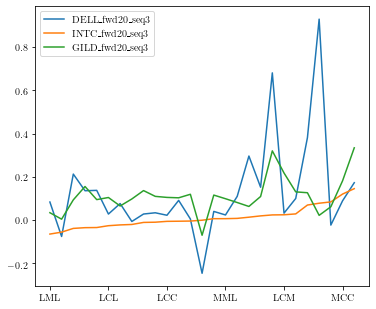

In [194]:
seqname = 'seq3'
fwdname = 'fwd20'

temp_seq = both_seq_pred[ [col for col in both_seq_pred.columns if seqname in col and fwdname in col] ].dropna()
temp_seq.sort_values(by=temp_seq.columns[1]).plot()

In [235]:
def rescale_plot(W=5, l=6, w=3, fontsize=10):
    plt.rcParams.update({
            'figure.figsize': (W, W/(l/w)),     # 6:3 aspect ratio
            'font.size' : fontsize,                   # Set font size to 11pt
            'axes.labelsize': fontsize,               # -> axis labels
            'legend.fontsize': fontsize,  
            'text.usetex': False,
            'text.latex.preamble':             # LaTeX preamble
                r"\usepackage{amssymb}\usepackage{lmodern}\usepackage{amsfonts}\usepackage{amsmath}"
                # ... more packages if needed
            
        })


array([[-1.83968192],
       [-1.40874305],
       [-1.23187888],
       [ 0.01709263],
       [-0.59749003],
       [-1.41502284],
       [-1.110966  ],
       [-0.19685647],
       [-1.27919415],
       [ 0.03545388],
       [ 0.38640337],
       [-0.6651794 ],
       [ 1.33662887],
       [-0.64161705],
       [ 0.36323977],
       [ 0.35087786],
       [ 0.62363486],
       [ 0.51626485],
       [ 0.418199  ],
       [ 0.11033364],
       [ 0.9108992 ],
       [ 0.25003304],
       [ 0.2472152 ],
       [ 0.8184267 ],
       [-0.2711955 ],
       [ 1.88239544],
       [ 2.39072699]])

Text(0.5, 1.0, 'Vol prediction (in ba spread)')

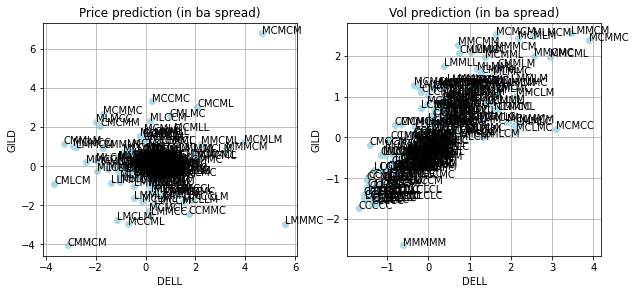

In [256]:
rescale_plot(10, 14, 6)

asset1  = 'DELL'
asset2  = 'GILD'
seqname = 'seq5'
fwdname = 'fwd50'

fig, (ax, ax2) = plt.subplots(1, 2)

temp_seq = both_seq_pred[ [col for col in both_seq_pred.columns if seqname in col and fwdname in col] ].dropna()
z = temp_seq[[col for col in temp_seq.columns if asset1 in col]].values
y = temp_seq[[col for col in temp_seq.columns if asset2 in col]].values
z = (z - np.mean(z)) / np.std(z); y = (y - np.mean(y)) / np.std(y)
ax.scatter(z, y, color='lightblue',marker='o')
for i, txt in enumerate(temp_seq.index):
    ax.annotate(str(txt), (z[i], y[i]))

    
temp_seq = both_seq_pred_std[ [col for col in both_seq_pred_std.columns if seqname in col and fwdname in col] ].dropna()
z = temp_seq[[col for col in temp_seq.columns if asset1 in col]].values
y = temp_seq[[col for col in temp_seq.columns if asset2 in col]].values
z = (z - np.mean(z)) / np.std(z); y = (y - np.mean(y)) / np.std(y)
ax2.scatter(z, y, color='lightblue')
for i, txt in enumerate(temp_seq.index):
    ax2.annotate(f'{txt}', (z[i], y[i]))
    
for x in (ax, ax2):
    x.grid('both')
    x.set_xlabel(asset1)
    x.set_ylabel(asset2)

ax.set_title(r'Price prediction (in ba spread)')
ax2.set_title(r'Vol prediction (in ba spread)')

In [93]:
#both_seq_pred.sort_values(by='fwd_INTC_l50_seq5').plot()

In [94]:
#both_seq_pred